#### Getting Started with BinsceneA

This notebook shows how to load the BinsceneA dataset in PyTorch, what kind of samples it contains and how they can be visualized and transformed.

In [1]:
import random
import matplotlib.pyplot as plt
from dataset_util.dataset import BinsceneA
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
# create an instance of the BinsceneA dataset
binscene_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='full', premultiply_alpha=True)
# display some information on the dataset
print(f'The dataset contains {len(binscene_dataset)} samples.')
print(f'It contains objects from the following {len(binscene_dataset.class_labels)} classes:')
print(binscene_dataset.class_labels, '\n')
# select a random sample index and load the corresponding data sample
sample_idx = random.randrange(len(binscene_dataset))
# 
img_tensor, object_visibility_vector = binscene_dataset.__getitem__(sample_idx)
trainloader = torch.utils.data.DataLoader(binscene_dataset, batch_size=32,
                                          shuffle=True, num_workers=2)
print('The shape of an image tensor is:', img_tensor.shape)
print('The shape of an object visibility vector is:', object_visibility_vector.shape)

The dataset contains 200000 samples.
It contains objects from the following 17 classes:
['cracker_box' 'sugar_box' 'mustard_bottle' 'potted_meat_can' 'banana'
 'bleach_cleanser' 'mug' 'sponge' 'spatula' 'power_drill' 'wood_block'
 'extra_large_clamp' 'softball' 'golf_ball' 'dice' 'toy_airplane'
 'red_box'] 

The shape of an image tensor is: torch.Size([3, 360, 640])
The shape of an object visibility vector is: torch.Size([17])


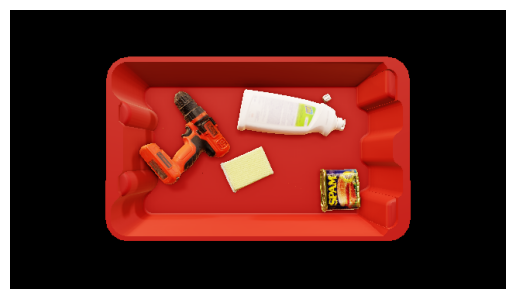

Visible objects are bleach_cleanser, dice, potted_meat_can, power_drill, red_box and sponge.


In [3]:
# we can also have the dataset visualize and describe a sample
fig, ax = plt.subplots()
ax, image_description = binscene_dataset.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

#### Transforms


Just like any PyTorch [VisionDataset](https://pytorch.org/vision/main/generated/torchvision.datasets.VisionDataset.html), the binscene datasets accept custom *transforms*, *transform* and *target_transform*. The cell below illustrates this by resizing the images when they are loaded. For more information about transforming data, see the [PyTorch Docs](https://pytorch.org/vision/main/transforms.html).

The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(0.9804)
The shape of the object visibility vector is: torch.Size([17])


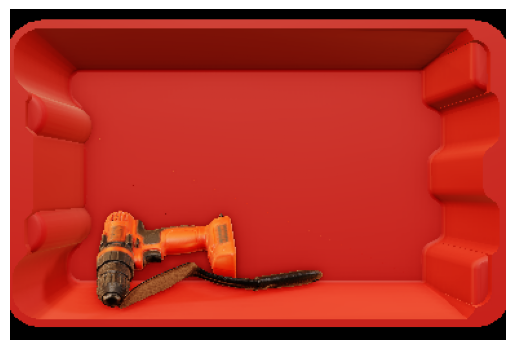

Visible objects are power_drill, red_box and spatula.


In [4]:
import torchvision
# we don't need this module to warn us about all kinds of stuff
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import Resize, CenterCrop, Compose

# transform is applied to the images, target transform is applied to the visibility vectors
# transformS is applied to a tuple of (image, visibility vector)
# These functions can be defined and chained as desired, but they expect torch tensors as inputs

# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
resize_transform = Resize(size=(90, 160), antialias=True)
crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset = BinsceneA(root='/data/BinsceneA_16_objects', split='train', premultiply_alpha=True, 
                                transform=crop_transform)
trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=32,
                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset))
img_tensor, object_visibility_vector = transformed_dataset.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape)
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

In [5]:
import torchvision.models as models

class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()
 
    def forward(self, x):
        return self.sigm(self.base_model(x))
 


In [6]:
learning_rate = 0.1

# Initialize the model
model = Resnext50(17)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=256, verbose=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
from tqdm.auto import tqdm

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
best_loss = 1e25
for epoch in range(2):
    running_loss = 0.0
    for i, data in tqdm(enumerate(trainloader, 0)):
    # get the inputs; data is a list of [inputs, labels]
        img_tensors, class_labels = [t.to(device) for t in data]
        class_labels = class_labels.squeeze(1).float()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #img_tensors = img_tensors.cuda()
        model = model.to(device)
        outputs = model(img_tensors)
        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()
        scheduler.step(loss.item())

        # print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 10:.3f}, best loss: {best_loss:.3f}')
            running_loss = 0.0
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'best_model_resNeXt50.pt')
print('Finished Training')

11it [00:04,  6.72it/s]

[1,    10] loss: 10.287, best loss: 0.693


21it [00:05,  8.28it/s]

[1,    20] loss: 1.744, best loss: 0.693


29it [00:09,  1.81it/s]

[1,    30] loss: 0.708, best loss: 0.590


41it [00:12,  4.60it/s]

[1,    40] loss: 0.585, best loss: 0.528


51it [00:14,  4.50it/s]

[1,    50] loss: 0.618, best loss: 0.523


61it [00:16,  7.63it/s]

[1,    60] loss: 0.661, best loss: 0.501


71it [00:17,  7.96it/s]

[1,    70] loss: 0.608, best loss: 0.501


81it [00:18,  8.14it/s]

[1,    80] loss: 0.583, best loss: 0.501


91it [00:20,  6.80it/s]

[1,    90] loss: 0.565, best loss: 0.498


101it [00:21,  8.18it/s]

[1,   100] loss: 0.665, best loss: 0.498


111it [00:22,  8.39it/s]

[1,   110] loss: 0.655, best loss: 0.498


121it [00:24,  8.08it/s]

[1,   120] loss: 0.636, best loss: 0.498


131it [00:25,  8.22it/s]

[1,   130] loss: 0.641, best loss: 0.498


141it [00:26,  8.33it/s]

[1,   140] loss: 0.678, best loss: 0.498


151it [00:28,  6.82it/s]

[1,   150] loss: 0.616, best loss: 0.484


161it [00:29,  8.31it/s]

[1,   160] loss: 0.598, best loss: 0.484


171it [00:30,  7.44it/s]

[1,   170] loss: 0.634, best loss: 0.484


181it [00:32,  8.04it/s]

[1,   180] loss: 0.768, best loss: 0.484


191it [00:33,  8.43it/s]

[1,   190] loss: 0.870, best loss: 0.484


201it [00:34,  8.23it/s]

[1,   200] loss: 0.840, best loss: 0.484


211it [00:35,  7.68it/s]

[1,   210] loss: 0.698, best loss: 0.484


221it [00:37,  8.22it/s]

[1,   220] loss: 0.837, best loss: 0.484


231it [00:38,  8.01it/s]

[1,   230] loss: 0.717, best loss: 0.484


241it [00:39,  8.22it/s]

[1,   240] loss: 0.663, best loss: 0.484


251it [00:40,  8.18it/s]

[1,   250] loss: 0.660, best loss: 0.484


261it [00:42,  7.65it/s]

[1,   260] loss: 0.789, best loss: 0.484


271it [00:43,  7.93it/s]

[1,   270] loss: 0.775, best loss: 0.484


281it [00:44,  8.16it/s]

[1,   280] loss: 0.672, best loss: 0.484


291it [00:45,  7.49it/s]

[1,   290] loss: 0.681, best loss: 0.484


301it [00:47,  7.95it/s]

[1,   300] loss: 0.685, best loss: 0.484


311it [00:48,  8.28it/s]

[1,   310] loss: 0.777, best loss: 0.484


321it [00:49,  7.74it/s]

[1,   320] loss: 0.721, best loss: 0.484


331it [00:51,  7.69it/s]

[1,   330] loss: 0.703, best loss: 0.484


341it [00:52,  7.80it/s]

[1,   340] loss: 0.667, best loss: 0.484


351it [00:53,  8.19it/s]

[1,   350] loss: 0.634, best loss: 0.484


361it [00:55,  5.48it/s]

[1,   360] loss: 0.698, best loss: 0.484


371it [00:56,  7.84it/s]

[1,   370] loss: 0.601, best loss: 0.484


381it [00:57,  7.58it/s]

[1,   380] loss: 0.670, best loss: 0.484


391it [00:58,  7.36it/s]

[1,   390] loss: 0.718, best loss: 0.484


401it [01:00,  7.72it/s]

[1,   400] loss: 0.606, best loss: 0.484


403it [01:00,  7.83it/s]

Epoch 00402: reducing learning rate of group 0 to 5.0000e-02.


411it [01:01,  7.90it/s]

[1,   410] loss: 0.567, best loss: 0.484


421it [01:03,  6.82it/s]

[1,   420] loss: 0.540, best loss: 0.471


431it [01:04,  8.07it/s]

[1,   430] loss: 0.550, best loss: 0.471


441it [01:05,  7.90it/s]

[1,   440] loss: 0.537, best loss: 0.471


451it [01:07,  7.83it/s]

[1,   450] loss: 0.557, best loss: 0.471


461it [01:08,  8.25it/s]

[1,   460] loss: 0.533, best loss: 0.471


471it [01:09,  8.02it/s]

[1,   470] loss: 0.566, best loss: 0.471


481it [01:10,  8.19it/s]

[1,   480] loss: 0.540, best loss: 0.471


491it [01:12,  8.35it/s]

[1,   490] loss: 0.532, best loss: 0.471


501it [01:13,  7.70it/s]

[1,   500] loss: 0.533, best loss: 0.471


511it [01:14,  8.11it/s]

[1,   510] loss: 0.543, best loss: 0.471


521it [01:15,  8.14it/s]

[1,   520] loss: 0.630, best loss: 0.471


531it [01:17,  8.20it/s]

[1,   530] loss: 0.559, best loss: 0.471


541it [01:18,  8.14it/s]

[1,   540] loss: 0.547, best loss: 0.471


551it [01:19,  8.00it/s]

[1,   550] loss: 0.551, best loss: 0.471


561it [01:20,  8.22it/s]

[1,   560] loss: 0.599, best loss: 0.471


571it [01:22,  7.96it/s]

[1,   570] loss: 0.561, best loss: 0.471


581it [01:23,  8.10it/s]

[1,   580] loss: 0.555, best loss: 0.471


591it [01:24,  8.07it/s]

[1,   590] loss: 0.553, best loss: 0.471


601it [01:25,  8.10it/s]

[1,   600] loss: 0.537, best loss: 0.471


611it [01:27,  7.95it/s]

[1,   610] loss: 0.573, best loss: 0.471


621it [01:28,  4.96it/s]

[1,   620] loss: 0.523, best loss: 0.459


631it [01:30,  7.92it/s]

[1,   630] loss: 0.538, best loss: 0.459


641it [01:31,  8.18it/s]

[1,   640] loss: 0.538, best loss: 0.459


651it [01:32,  7.66it/s]

[1,   650] loss: 0.557, best loss: 0.459


661it [01:33,  7.83it/s]

[1,   660] loss: 0.535, best loss: 0.459


671it [01:35,  7.99it/s]

[1,   670] loss: 0.531, best loss: 0.459


681it [01:36,  7.71it/s]

[1,   680] loss: 0.527, best loss: 0.459


691it [01:37,  7.76it/s]

[1,   690] loss: 0.540, best loss: 0.459


701it [01:38,  7.95it/s]

[1,   700] loss: 0.543, best loss: 0.459


711it [01:40,  7.91it/s]

[1,   710] loss: 0.534, best loss: 0.459


721it [01:41,  7.78it/s]

[1,   720] loss: 0.529, best loss: 0.459


731it [01:42,  8.09it/s]

[1,   730] loss: 0.583, best loss: 0.459


741it [01:43,  8.10it/s]

[1,   740] loss: 0.544, best loss: 0.459


751it [01:45,  7.74it/s]

[1,   750] loss: 0.530, best loss: 0.459


761it [01:46,  8.17it/s]

[1,   760] loss: 0.545, best loss: 0.459


771it [01:47,  7.92it/s]

[1,   770] loss: 0.527, best loss: 0.459


781it [01:48,  7.94it/s]

[1,   780] loss: 0.543, best loss: 0.459


791it [01:50,  8.13it/s]

[1,   790] loss: 0.628, best loss: 0.459


801it [01:51,  8.22it/s]

[1,   800] loss: 0.535, best loss: 0.459


811it [01:52,  7.73it/s]

[1,   810] loss: 0.549, best loss: 0.459


821it [01:54,  7.54it/s]

[1,   820] loss: 0.529, best loss: 0.459


831it [01:55,  8.18it/s]

[1,   830] loss: 0.538, best loss: 0.459


841it [01:56,  8.04it/s]

[1,   840] loss: 0.537, best loss: 0.459


851it [01:57,  8.11it/s]

[1,   850] loss: 0.551, best loss: 0.459


861it [01:58,  8.27it/s]

[1,   860] loss: 0.527, best loss: 0.459


871it [02:00,  8.07it/s]

[1,   870] loss: 0.536, best loss: 0.459


877it [02:00,  8.19it/s]

Epoch 00876: reducing learning rate of group 0 to 2.5000e-02.


881it [02:01,  8.31it/s]

[1,   880] loss: 0.529, best loss: 0.459


891it [02:02,  7.63it/s]

[1,   890] loss: 0.528, best loss: 0.459


901it [02:03,  7.71it/s]

[1,   900] loss: 0.526, best loss: 0.459


911it [02:05,  7.33it/s]

[1,   910] loss: 0.530, best loss: 0.459


921it [02:06,  7.84it/s]

[1,   920] loss: 0.535, best loss: 0.459


931it [02:07,  7.76it/s]

[1,   930] loss: 0.522, best loss: 0.459


941it [02:09,  8.23it/s]

[1,   940] loss: 0.516, best loss: 0.459


951it [02:10,  8.23it/s]

[1,   950] loss: 0.528, best loss: 0.459


961it [02:11,  8.27it/s]

[1,   960] loss: 0.509, best loss: 0.459


971it [02:12,  8.12it/s]

[1,   970] loss: 0.509, best loss: 0.459


981it [02:13,  8.45it/s]

[1,   980] loss: 0.527, best loss: 0.459


991it [02:15,  7.24it/s]

[1,   990] loss: 0.516, best loss: 0.459


1001it [02:16,  8.41it/s]

[1,  1000] loss: 0.524, best loss: 0.459


1011it [02:17,  8.17it/s]

[1,  1010] loss: 0.512, best loss: 0.459


1021it [02:18,  8.26it/s]

[1,  1020] loss: 0.541, best loss: 0.459


1031it [02:20,  8.05it/s]

[1,  1030] loss: 0.524, best loss: 0.459


1041it [02:21,  8.28it/s]

[1,  1040] loss: 0.530, best loss: 0.459


1051it [02:22,  8.13it/s]

[1,  1050] loss: 0.513, best loss: 0.459


1061it [02:23,  7.81it/s]

[1,  1060] loss: 0.510, best loss: 0.459


1071it [02:25,  7.82it/s]

[1,  1070] loss: 0.521, best loss: 0.459


1081it [02:26,  8.05it/s]

[1,  1080] loss: 0.531, best loss: 0.459


1091it [02:27,  7.90it/s]

[1,  1090] loss: 0.528, best loss: 0.459


1101it [02:29,  7.40it/s]

[1,  1100] loss: 0.529, best loss: 0.459


1111it [02:30,  8.13it/s]

[1,  1110] loss: 0.519, best loss: 0.459


1121it [02:32,  7.62it/s]

[1,  1120] loss: 0.516, best loss: 0.447


1131it [02:33,  8.02it/s]

[1,  1130] loss: 0.627, best loss: 0.447


1141it [02:34,  8.33it/s]

[1,  1140] loss: 0.567, best loss: 0.447


1151it [02:35,  8.42it/s]

[1,  1150] loss: 0.539, best loss: 0.447


1161it [02:37,  8.50it/s]

[1,  1160] loss: 0.524, best loss: 0.447


1171it [02:38,  7.35it/s]

[1,  1170] loss: 0.536, best loss: 0.447


1181it [02:39,  8.09it/s]

[1,  1180] loss: 0.545, best loss: 0.447


1191it [02:40,  7.83it/s]

[1,  1190] loss: 0.548, best loss: 0.447


1201it [02:42,  7.57it/s]

[1,  1200] loss: 0.541, best loss: 0.447


1211it [02:43,  7.73it/s]

[1,  1210] loss: 0.521, best loss: 0.447


1221it [02:44,  8.29it/s]

[1,  1220] loss: 0.525, best loss: 0.447


1231it [02:45,  8.50it/s]

[1,  1230] loss: 0.526, best loss: 0.447


1241it [02:47,  8.35it/s]

[1,  1240] loss: 0.529, best loss: 0.447


1251it [02:48,  8.47it/s]

[1,  1250] loss: 0.529, best loss: 0.447


1261it [02:50,  6.44it/s]

[1,  1260] loss: 0.515, best loss: 0.447


1271it [02:52,  4.08it/s]

[1,  1270] loss: 0.531, best loss: 0.447


1281it [02:53,  7.85it/s]

[1,  1280] loss: 0.529, best loss: 0.447


1291it [02:54,  8.06it/s]

[1,  1290] loss: 0.515, best loss: 0.447


1301it [02:56,  8.11it/s]

[1,  1300] loss: 0.532, best loss: 0.447


1311it [02:57,  8.24it/s]

[1,  1310] loss: 0.517, best loss: 0.447


1321it [02:58,  8.26it/s]

[1,  1320] loss: 0.530, best loss: 0.447


1331it [02:59,  8.39it/s]

[1,  1330] loss: 0.510, best loss: 0.447


1341it [03:00,  8.34it/s]

[1,  1340] loss: 0.520, best loss: 0.447


1351it [03:02,  8.37it/s]

[1,  1350] loss: 0.529, best loss: 0.447


1361it [03:03,  8.13it/s]

[1,  1360] loss: 0.537, best loss: 0.447


1371it [03:04,  7.13it/s]

Epoch 01370: reducing learning rate of group 0 to 1.2500e-02.
[1,  1370] loss: 0.539, best loss: 0.447


1381it [03:05,  8.36it/s]

[1,  1380] loss: 0.513, best loss: 0.447


1391it [03:07,  8.29it/s]

[1,  1390] loss: 0.526, best loss: 0.447


1401it [03:08,  7.99it/s]

[1,  1400] loss: 0.525, best loss: 0.447


1411it [03:09,  8.36it/s]

[1,  1410] loss: 0.506, best loss: 0.447


1421it [03:10,  8.13it/s]

[1,  1420] loss: 0.504, best loss: 0.447


1431it [03:12,  7.38it/s]

[1,  1430] loss: 0.507, best loss: 0.447


1441it [03:13,  8.15it/s]

[1,  1440] loss: 0.528, best loss: 0.447


1451it [03:14,  8.36it/s]

[1,  1450] loss: 0.537, best loss: 0.447


1461it [03:15,  7.78it/s]

[1,  1460] loss: 0.530, best loss: 0.447


1471it [03:17,  8.31it/s]

[1,  1470] loss: 0.524, best loss: 0.447


1481it [03:18,  8.39it/s]

[1,  1480] loss: 0.519, best loss: 0.447


1491it [03:19,  8.10it/s]

[1,  1490] loss: 0.527, best loss: 0.447


1501it [03:20,  8.19it/s]

[1,  1500] loss: 0.513, best loss: 0.447


1511it [03:21,  8.20it/s]

[1,  1510] loss: 0.500, best loss: 0.447


1521it [03:23,  8.07it/s]

[1,  1520] loss: 0.518, best loss: 0.447


1531it [03:24,  8.14it/s]

[1,  1530] loss: 0.525, best loss: 0.447


1541it [03:25,  8.00it/s]

[1,  1540] loss: 0.515, best loss: 0.447


1551it [03:26,  8.10it/s]

[1,  1550] loss: 0.507, best loss: 0.447


1561it [03:28,  8.19it/s]

[1,  1560] loss: 0.527, best loss: 0.447


1571it [03:29,  8.34it/s]

[1,  1570] loss: 0.512, best loss: 0.447


1581it [03:30,  8.15it/s]

[1,  1580] loss: 0.520, best loss: 0.447


1591it [03:31,  8.29it/s]

[1,  1590] loss: 0.525, best loss: 0.447


1601it [03:32,  8.12it/s]

[1,  1600] loss: 0.525, best loss: 0.447


1611it [03:34,  7.10it/s]

[1,  1610] loss: 0.510, best loss: 0.447


1621it [03:35,  8.21it/s]

[1,  1620] loss: 0.531, best loss: 0.447


1628it [03:36,  7.78it/s]

Epoch 01627: reducing learning rate of group 0 to 6.2500e-03.


1631it [03:36,  7.11it/s]

[1,  1630] loss: 0.527, best loss: 0.447


1641it [03:38,  8.13it/s]

[1,  1640] loss: 0.519, best loss: 0.447


1651it [03:39,  8.33it/s]

[1,  1650] loss: 0.512, best loss: 0.447


1661it [03:40,  8.10it/s]

[1,  1660] loss: 0.512, best loss: 0.447


1671it [03:41,  8.22it/s]

[1,  1670] loss: 0.510, best loss: 0.447


1681it [03:43,  8.05it/s]

[1,  1680] loss: 0.503, best loss: 0.447


1691it [03:44,  7.48it/s]

[1,  1690] loss: 0.505, best loss: 0.447


1701it [03:45,  8.29it/s]

[1,  1700] loss: 0.510, best loss: 0.447


1711it [03:46,  8.06it/s]

[1,  1710] loss: 0.533, best loss: 0.447


1721it [03:48,  8.11it/s]

[1,  1720] loss: 0.518, best loss: 0.447


1731it [03:49,  8.27it/s]

[1,  1730] loss: 0.531, best loss: 0.447


1741it [03:50,  8.21it/s]

[1,  1740] loss: 0.522, best loss: 0.447


1751it [03:51,  8.09it/s]

[1,  1750] loss: 0.501, best loss: 0.447


1761it [03:52,  8.25it/s]

[1,  1760] loss: 0.524, best loss: 0.447


1771it [03:54,  7.98it/s]

[1,  1770] loss: 0.511, best loss: 0.447


1781it [03:55,  8.07it/s]

[1,  1780] loss: 0.529, best loss: 0.447


1791it [03:56,  8.36it/s]

[1,  1790] loss: 0.534, best loss: 0.447


1801it [03:57,  8.02it/s]

[1,  1800] loss: 0.521, best loss: 0.447


1811it [03:59,  8.10it/s]

[1,  1810] loss: 0.517, best loss: 0.447


1820it [04:00,  8.43it/s]

[1,  1820] loss: 0.510, best loss: 0.447


1831it [04:02,  7.71it/s]

[1,  1830] loss: 0.524, best loss: 0.447


1841it [04:03,  8.20it/s]

[1,  1840] loss: 0.523, best loss: 0.447


1851it [04:04,  8.10it/s]

[1,  1850] loss: 0.519, best loss: 0.447


1861it [04:06,  6.97it/s]

[1,  1860] loss: 0.521, best loss: 0.447


1871it [04:07,  8.15it/s]

[1,  1870] loss: 0.514, best loss: 0.447


1881it [04:08,  7.74it/s]

[1,  1880] loss: 0.510, best loss: 0.447


1885it [04:09,  8.13it/s]

Epoch 01884: reducing learning rate of group 0 to 3.1250e-03.


1891it [04:09,  7.84it/s]

[1,  1890] loss: 0.520, best loss: 0.447


1901it [04:11,  7.39it/s]

[1,  1900] loss: 0.519, best loss: 0.447


1911it [04:12,  7.59it/s]

[1,  1910] loss: 0.506, best loss: 0.447


1921it [04:13,  8.07it/s]

[1,  1920] loss: 0.521, best loss: 0.447


1931it [04:15,  8.07it/s]

[1,  1930] loss: 0.523, best loss: 0.447


1941it [04:16,  8.09it/s]

[1,  1940] loss: 0.516, best loss: 0.447


1951it [04:17,  8.29it/s]

[1,  1950] loss: 0.514, best loss: 0.447


1961it [04:18,  8.08it/s]

[1,  1960] loss: 0.512, best loss: 0.447


1971it [04:20,  8.26it/s]

[1,  1970] loss: 0.516, best loss: 0.447


1981it [04:21,  7.65it/s]

[1,  1980] loss: 0.517, best loss: 0.447


1991it [04:22,  7.42it/s]

[1,  1990] loss: 0.521, best loss: 0.447


2001it [04:23,  7.89it/s]

[1,  2000] loss: 0.533, best loss: 0.447


2011it [04:25,  8.02it/s]

[1,  2010] loss: 0.521, best loss: 0.447


2021it [04:26,  8.29it/s]

[1,  2020] loss: 0.521, best loss: 0.447


2031it [04:27,  8.35it/s]

[1,  2030] loss: 0.509, best loss: 0.447


2041it [04:29,  7.60it/s]

[1,  2040] loss: 0.532, best loss: 0.447


2051it [04:30,  8.24it/s]

[1,  2050] loss: 0.520, best loss: 0.447


2061it [04:31,  6.97it/s]

[1,  2060] loss: 0.506, best loss: 0.447


2071it [04:33,  7.94it/s]

[1,  2070] loss: 0.521, best loss: 0.447


2081it [04:34,  8.00it/s]

[1,  2080] loss: 0.515, best loss: 0.447


2091it [04:35,  7.90it/s]

[1,  2090] loss: 0.509, best loss: 0.447


2101it [04:36,  8.17it/s]

[1,  2100] loss: 0.525, best loss: 0.447


2111it [04:38,  8.31it/s]

[1,  2110] loss: 0.510, best loss: 0.447


2121it [04:39,  8.22it/s]

[1,  2120] loss: 0.511, best loss: 0.447


2131it [04:40,  7.37it/s]

[1,  2130] loss: 0.516, best loss: 0.447


2141it [04:41,  8.11it/s]

[1,  2140] loss: 0.518, best loss: 0.447
Epoch 02141: reducing learning rate of group 0 to 1.5625e-03.


2151it [04:43,  8.27it/s]

[1,  2150] loss: 0.516, best loss: 0.447


2161it [04:44,  8.11it/s]

[1,  2160] loss: 0.513, best loss: 0.447


2171it [04:45,  8.42it/s]

[1,  2170] loss: 0.519, best loss: 0.447


2181it [04:46,  8.32it/s]

[1,  2180] loss: 0.511, best loss: 0.447


2191it [04:48,  8.34it/s]

[1,  2190] loss: 0.511, best loss: 0.447


2201it [04:49,  8.38it/s]

[1,  2200] loss: 0.511, best loss: 0.447


2211it [04:50,  7.99it/s]

[1,  2210] loss: 0.507, best loss: 0.447


2221it [04:51,  8.15it/s]

[1,  2220] loss: 0.520, best loss: 0.447


2231it [04:52,  8.34it/s]

[1,  2230] loss: 0.518, best loss: 0.447


2241it [04:54,  8.31it/s]

[1,  2240] loss: 0.501, best loss: 0.447


2251it [04:55,  8.37it/s]

[1,  2250] loss: 0.507, best loss: 0.447


2261it [04:56,  7.97it/s]

[1,  2260] loss: 0.500, best loss: 0.447


2271it [04:57,  7.76it/s]

[1,  2270] loss: 0.514, best loss: 0.447


2281it [04:59,  8.30it/s]

[1,  2280] loss: 0.521, best loss: 0.447


2291it [05:00,  8.39it/s]

[1,  2290] loss: 0.513, best loss: 0.447


2301it [05:01,  8.25it/s]

[1,  2300] loss: 0.511, best loss: 0.447


2311it [05:02,  8.08it/s]

[1,  2310] loss: 0.515, best loss: 0.447


2320it [05:03,  8.19it/s]

[1,  2320] loss: 0.512, best loss: 0.447


2331it [05:05,  7.56it/s]

[1,  2330] loss: 0.519, best loss: 0.443


2341it [05:07,  7.97it/s]

[1,  2340] loss: 0.509, best loss: 0.443


2351it [05:08,  8.11it/s]

[1,  2350] loss: 0.516, best loss: 0.443


2361it [05:09,  7.83it/s]

[1,  2360] loss: 0.520, best loss: 0.443


2371it [05:10,  7.76it/s]

[1,  2370] loss: 0.520, best loss: 0.443


2381it [05:12,  7.54it/s]

[1,  2380] loss: 0.517, best loss: 0.443


2391it [05:13,  8.14it/s]

[1,  2390] loss: 0.515, best loss: 0.443


2401it [05:14,  8.25it/s]

[1,  2400] loss: 0.518, best loss: 0.443


2411it [05:15,  7.82it/s]

[1,  2410] loss: 0.508, best loss: 0.443


2421it [05:17,  8.39it/s]

[1,  2420] loss: 0.512, best loss: 0.443


2431it [05:18,  7.99it/s]

[1,  2430] loss: 0.507, best loss: 0.443


2441it [05:19,  8.14it/s]

[1,  2440] loss: 0.510, best loss: 0.443


2451it [05:20,  7.77it/s]

[1,  2450] loss: 0.517, best loss: 0.443


2461it [05:21,  8.26it/s]

[1,  2460] loss: 0.520, best loss: 0.443


2471it [05:23,  8.25it/s]

[1,  2470] loss: 0.526, best loss: 0.443


2481it [05:24,  8.10it/s]

[1,  2480] loss: 0.510, best loss: 0.443


2491it [05:25,  7.76it/s]

[1,  2490] loss: 0.518, best loss: 0.443


2501it [05:26,  8.41it/s]

[1,  2500] loss: 0.515, best loss: 0.443


2511it [05:28,  8.19it/s]

[1,  2510] loss: 0.524, best loss: 0.443


2521it [05:29,  8.29it/s]

[1,  2520] loss: 0.534, best loss: 0.443


2531it [05:30,  8.34it/s]

[1,  2530] loss: 0.515, best loss: 0.443


2541it [05:31,  8.21it/s]

[1,  2540] loss: 0.505, best loss: 0.443


2551it [05:32,  8.27it/s]

[1,  2550] loss: 0.528, best loss: 0.443


2561it [05:34,  8.14it/s]

[1,  2560] loss: 0.520, best loss: 0.443


2571it [05:35,  8.36it/s]

[1,  2570] loss: 0.515, best loss: 0.443


2579it [05:36,  8.29it/s]

Epoch 02578: reducing learning rate of group 0 to 7.8125e-04.


2581it [05:36,  8.20it/s]

[1,  2580] loss: 0.503, best loss: 0.443


2591it [05:37,  8.30it/s]

[1,  2590] loss: 0.528, best loss: 0.443


2601it [05:38,  8.31it/s]

[1,  2600] loss: 0.523, best loss: 0.443


2611it [05:40,  8.21it/s]

[1,  2610] loss: 0.519, best loss: 0.443


2621it [05:41,  8.26it/s]

[1,  2620] loss: 0.522, best loss: 0.443


2631it [05:42,  8.36it/s]

[1,  2630] loss: 0.516, best loss: 0.443


2641it [05:43,  8.30it/s]

[1,  2640] loss: 0.507, best loss: 0.443


2651it [05:45,  7.77it/s]

[1,  2650] loss: 0.505, best loss: 0.443


2661it [05:46,  7.67it/s]

[1,  2660] loss: 0.505, best loss: 0.443


2671it [05:47,  8.14it/s]

[1,  2670] loss: 0.513, best loss: 0.443


2681it [05:48,  7.76it/s]

[1,  2680] loss: 0.517, best loss: 0.443


2691it [05:50,  7.86it/s]

[1,  2690] loss: 0.505, best loss: 0.443


2701it [05:51,  7.84it/s]

[1,  2700] loss: 0.525, best loss: 0.443


2711it [05:52,  7.66it/s]

[1,  2710] loss: 0.522, best loss: 0.443


2721it [05:54,  7.78it/s]

[1,  2720] loss: 0.503, best loss: 0.443


2731it [05:55,  8.11it/s]

[1,  2730] loss: 0.516, best loss: 0.443


2741it [05:56,  8.34it/s]

[1,  2740] loss: 0.523, best loss: 0.443


2751it [05:57,  7.97it/s]

[1,  2750] loss: 0.501, best loss: 0.443


2761it [05:58,  8.28it/s]

[1,  2760] loss: 0.522, best loss: 0.443


2771it [06:00,  7.96it/s]

[1,  2770] loss: 0.516, best loss: 0.443


2781it [06:01,  7.75it/s]

[1,  2780] loss: 0.510, best loss: 0.443


2791it [06:02,  8.02it/s]

[1,  2790] loss: 0.520, best loss: 0.443


2801it [06:03,  8.03it/s]

[1,  2800] loss: 0.519, best loss: 0.443


2811it [06:05,  7.59it/s]

[1,  2810] loss: 0.525, best loss: 0.443


2821it [06:06,  8.00it/s]

[1,  2820] loss: 0.516, best loss: 0.443


2831it [06:07,  7.85it/s]

[1,  2830] loss: 0.519, best loss: 0.443


2836it [06:08,  7.40it/s]

Epoch 02835: reducing learning rate of group 0 to 3.9063e-04.


2841it [06:09,  7.85it/s]

[1,  2840] loss: 0.523, best loss: 0.443


2851it [06:10,  7.47it/s]

[1,  2850] loss: 0.499, best loss: 0.443


2861it [06:11,  7.98it/s]

[1,  2860] loss: 0.507, best loss: 0.443


2871it [06:12,  8.31it/s]

[1,  2870] loss: 0.514, best loss: 0.443


2881it [06:14,  8.29it/s]

[1,  2880] loss: 0.499, best loss: 0.443


2891it [06:15,  7.69it/s]

[1,  2890] loss: 0.513, best loss: 0.443


2901it [06:16,  7.38it/s]

[1,  2900] loss: 0.502, best loss: 0.443


2911it [06:18,  8.23it/s]

[1,  2910] loss: 0.510, best loss: 0.443


2921it [06:19,  8.28it/s]

[1,  2920] loss: 0.514, best loss: 0.443


2931it [06:20,  8.37it/s]

[1,  2930] loss: 0.519, best loss: 0.443


2941it [06:21,  8.23it/s]

[1,  2940] loss: 0.512, best loss: 0.443


2951it [06:22,  7.91it/s]

[1,  2950] loss: 0.515, best loss: 0.443


2961it [06:24,  8.20it/s]

[1,  2960] loss: 0.508, best loss: 0.443


2971it [06:25,  8.27it/s]

[1,  2970] loss: 0.520, best loss: 0.443


2981it [06:26,  8.23it/s]

[1,  2980] loss: 0.500, best loss: 0.443


2991it [06:27,  7.94it/s]

[1,  2990] loss: 0.516, best loss: 0.443


3001it [06:28,  8.27it/s]

[1,  3000] loss: 0.509, best loss: 0.443


3011it [06:30,  7.97it/s]

[1,  3010] loss: 0.524, best loss: 0.443


3021it [06:31,  7.75it/s]

[1,  3020] loss: 0.507, best loss: 0.443


3031it [06:32,  7.52it/s]

[1,  3030] loss: 0.496, best loss: 0.443


3041it [06:34,  7.52it/s]

[1,  3040] loss: 0.516, best loss: 0.443


3051it [06:35,  8.22it/s]

[1,  3050] loss: 0.523, best loss: 0.443


3061it [06:36,  8.13it/s]

[1,  3060] loss: 0.517, best loss: 0.443


3071it [06:37,  8.38it/s]

[1,  3070] loss: 0.538, best loss: 0.443


3081it [06:39,  7.99it/s]

[1,  3080] loss: 0.512, best loss: 0.443


3091it [06:40,  7.50it/s]

[1,  3090] loss: 0.516, best loss: 0.443


3093it [06:40,  7.45it/s]

Epoch 03092: reducing learning rate of group 0 to 1.9531e-04.


3101it [06:41,  7.94it/s]

[1,  3100] loss: 0.519, best loss: 0.443


3111it [06:42,  8.19it/s]

[1,  3110] loss: 0.501, best loss: 0.443


3121it [06:44,  8.22it/s]

[1,  3120] loss: 0.510, best loss: 0.443


3131it [06:45,  7.70it/s]

[1,  3130] loss: 0.516, best loss: 0.443


3141it [06:46,  7.66it/s]

[1,  3140] loss: 0.520, best loss: 0.443


3151it [06:47,  8.26it/s]

[1,  3150] loss: 0.515, best loss: 0.443


3161it [06:49,  8.11it/s]

[1,  3160] loss: 0.514, best loss: 0.443


3171it [06:50,  8.38it/s]

[1,  3170] loss: 0.508, best loss: 0.443


3181it [06:51,  8.20it/s]

[1,  3180] loss: 0.515, best loss: 0.443


3191it [06:52,  8.39it/s]

[1,  3190] loss: 0.508, best loss: 0.443


3201it [06:54,  8.08it/s]

[1,  3200] loss: 0.502, best loss: 0.443


3211it [06:55,  8.16it/s]

[1,  3210] loss: 0.507, best loss: 0.443


3221it [06:56,  8.31it/s]

[1,  3220] loss: 0.510, best loss: 0.443


3231it [06:57,  8.32it/s]

[1,  3230] loss: 0.505, best loss: 0.443


3241it [06:58,  7.90it/s]

[1,  3240] loss: 0.511, best loss: 0.443


3251it [07:00,  8.01it/s]

[1,  3250] loss: 0.506, best loss: 0.443


3261it [07:01,  7.77it/s]

[1,  3260] loss: 0.506, best loss: 0.443


3271it [07:02,  7.74it/s]

[1,  3270] loss: 0.505, best loss: 0.443


3281it [07:04,  8.06it/s]

[1,  3280] loss: 0.507, best loss: 0.443


3291it [07:05,  8.02it/s]

[1,  3290] loss: 0.527, best loss: 0.443


3301it [07:06,  8.29it/s]

[1,  3300] loss: 0.519, best loss: 0.443


3311it [07:07,  8.31it/s]

[1,  3310] loss: 0.512, best loss: 0.443


3321it [07:08,  8.36it/s]

[1,  3320] loss: 0.518, best loss: 0.443


3331it [07:10,  8.04it/s]

[1,  3330] loss: 0.511, best loss: 0.443


3341it [07:11,  8.08it/s]

[1,  3340] loss: 0.511, best loss: 0.443


3350it [07:12,  8.29it/s]

Epoch 03349: reducing learning rate of group 0 to 9.7656e-05.
[1,  3350] loss: 0.502, best loss: 0.443


3361it [07:13,  7.54it/s]

[1,  3360] loss: 0.510, best loss: 0.443


3371it [07:15,  8.16it/s]

[1,  3370] loss: 0.510, best loss: 0.443


3381it [07:16,  8.43it/s]

[1,  3380] loss: 0.516, best loss: 0.443


3391it [07:18,  6.31it/s]

[1,  3390] loss: 0.503, best loss: 0.443


3401it [07:19,  8.25it/s]

[1,  3400] loss: 0.506, best loss: 0.443


3411it [07:20,  8.45it/s]

[1,  3410] loss: 0.514, best loss: 0.443


3421it [07:21,  8.38it/s]

[1,  3420] loss: 0.512, best loss: 0.443


3431it [07:23,  8.14it/s]

[1,  3430] loss: 0.524, best loss: 0.443


3441it [07:24,  8.32it/s]

[1,  3440] loss: 0.524, best loss: 0.443


3451it [07:25,  8.35it/s]

[1,  3450] loss: 0.507, best loss: 0.443


3461it [07:26,  8.22it/s]

[1,  3460] loss: 0.516, best loss: 0.443


3471it [07:27,  8.25it/s]

[1,  3470] loss: 0.511, best loss: 0.443


3481it [07:29,  8.32it/s]

[1,  3480] loss: 0.518, best loss: 0.443


3491it [07:30,  8.17it/s]

[1,  3490] loss: 0.511, best loss: 0.443


3501it [07:31,  8.28it/s]

[1,  3500] loss: 0.529, best loss: 0.443


3511it [07:32,  8.26it/s]

[1,  3510] loss: 0.517, best loss: 0.443


3521it [07:33,  8.25it/s]

[1,  3520] loss: 0.515, best loss: 0.443


3531it [07:35,  8.13it/s]

[1,  3530] loss: 0.509, best loss: 0.443


3541it [07:36,  8.26it/s]

[1,  3540] loss: 0.507, best loss: 0.443


3551it [07:37,  8.35it/s]

[1,  3550] loss: 0.497, best loss: 0.443


3561it [07:38,  8.21it/s]

[1,  3560] loss: 0.520, best loss: 0.443


3571it [07:40,  8.36it/s]

[1,  3570] loss: 0.513, best loss: 0.443


3581it [07:41,  8.08it/s]

[1,  3580] loss: 0.514, best loss: 0.443


3591it [07:42,  7.83it/s]

[1,  3590] loss: 0.513, best loss: 0.443


3601it [07:43,  7.97it/s]

[1,  3600] loss: 0.524, best loss: 0.443


3611it [07:45,  8.12it/s]

[1,  3610] loss: 0.530, best loss: 0.443


3621it [07:46,  8.11it/s]

[1,  3620] loss: 0.515, best loss: 0.443


3631it [07:47,  8.58it/s]

[1,  3630] loss: 0.510, best loss: 0.443


3641it [07:48,  8.22it/s]

[1,  3640] loss: 0.525, best loss: 0.443


3645it [07:49,  8.24it/s]

Epoch 03644: reducing learning rate of group 0 to 4.8828e-05.


3651it [07:49,  8.26it/s]

[1,  3650] loss: 0.524, best loss: 0.443


3661it [07:51,  8.22it/s]

[1,  3660] loss: 0.503, best loss: 0.443


3671it [07:52,  8.16it/s]

[1,  3670] loss: 0.503, best loss: 0.443


3681it [07:53,  7.68it/s]

[1,  3680] loss: 0.512, best loss: 0.443


3691it [07:54,  7.90it/s]

[1,  3690] loss: 0.509, best loss: 0.443


3701it [07:56,  6.60it/s]

[1,  3700] loss: 0.486, best loss: 0.414


3711it [07:58,  7.91it/s]

[1,  3710] loss: 0.524, best loss: 0.414


3721it [07:59,  8.34it/s]

[1,  3720] loss: 0.514, best loss: 0.414


3731it [08:00,  8.29it/s]

[1,  3730] loss: 0.519, best loss: 0.414


3741it [08:01,  8.27it/s]

[1,  3740] loss: 0.517, best loss: 0.414


3751it [08:02,  8.38it/s]

[1,  3750] loss: 0.509, best loss: 0.414


3761it [08:04,  8.27it/s]

[1,  3760] loss: 0.518, best loss: 0.414


3771it [08:05,  8.11it/s]

[1,  3770] loss: 0.513, best loss: 0.414


3781it [08:06,  8.51it/s]

[1,  3780] loss: 0.505, best loss: 0.414


3791it [08:07,  8.34it/s]

[1,  3790] loss: 0.517, best loss: 0.414


3801it [08:08,  8.31it/s]

[1,  3800] loss: 0.527, best loss: 0.414


3811it [08:10,  8.39it/s]

[1,  3810] loss: 0.511, best loss: 0.414


3821it [08:11,  8.21it/s]

[1,  3820] loss: 0.506, best loss: 0.414


3831it [08:12,  8.28it/s]

[1,  3830] loss: 0.519, best loss: 0.414


3841it [08:13,  8.42it/s]

[1,  3840] loss: 0.519, best loss: 0.414


3851it [08:15,  8.29it/s]

[1,  3850] loss: 0.494, best loss: 0.414


3861it [08:16,  7.86it/s]

[1,  3860] loss: 0.518, best loss: 0.414


3871it [08:17,  7.82it/s]

[1,  3870] loss: 0.525, best loss: 0.414


3881it [08:18,  7.67it/s]

[1,  3880] loss: 0.524, best loss: 0.414


3891it [08:20,  7.58it/s]

[1,  3890] loss: 0.493, best loss: 0.414


3901it [08:21,  7.65it/s]

[1,  3900] loss: 0.507, best loss: 0.414


3911it [08:22,  7.80it/s]

[1,  3910] loss: 0.500, best loss: 0.414


3921it [08:24,  8.01it/s]

[1,  3920] loss: 0.514, best loss: 0.414


3931it [08:25,  7.54it/s]

[1,  3930] loss: 0.513, best loss: 0.414


3941it [08:26,  8.00it/s]

[1,  3940] loss: 0.498, best loss: 0.414


3951it [08:27,  8.11it/s]

[1,  3950] loss: 0.527, best loss: 0.414


3953it [08:28,  7.98it/s]

Epoch 03952: reducing learning rate of group 0 to 2.4414e-05.


3961it [08:29,  7.64it/s]

[1,  3960] loss: 0.496, best loss: 0.414


3971it [08:30,  7.95it/s]

[1,  3970] loss: 0.509, best loss: 0.414


3981it [08:31,  7.91it/s]

[1,  3980] loss: 0.527, best loss: 0.414


3991it [08:32,  7.89it/s]

[1,  3990] loss: 0.521, best loss: 0.414


4001it [08:34,  8.02it/s]

[1,  4000] loss: 0.522, best loss: 0.414


4011it [08:35,  8.06it/s]

[1,  4010] loss: 0.512, best loss: 0.414


4018it [08:36,  7.78it/s]


KeyboardInterrupt: 

The shape of the image tensor is: torch.Size([3, 256, 384]) tensor(0.) tensor(1.)
The shape of the object visibility vector is: torch.Size([17]) torch.BoolTensor


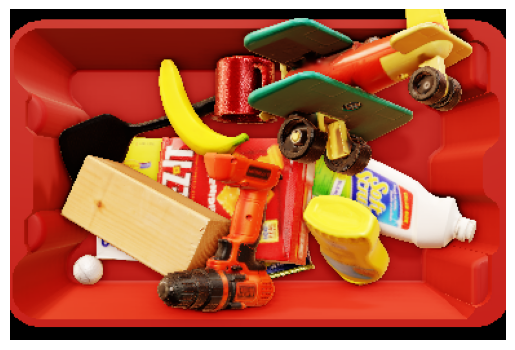

Visible objects are banana, bleach_cleanser, cracker_box, golf_ball, mug, mustard_bottle, potted_meat_can, power_drill, red_box, spatula, sugar_box, toy_airplane and wood_block.
tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True])
tensor([ True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False, False,  True, False,  True,  True]) tensor(0.7647)


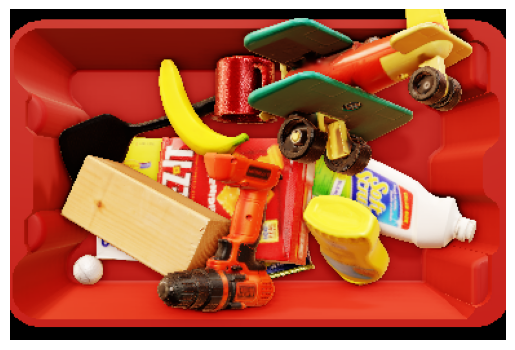

Model output
Visible objects are banana, bleach_cleanser, cracker_box, dice, extra_large_clamp, golf_ball, mug, mustard_bottle, potted_meat_can, power_drill, red_box, softball, spatula, sponge, sugar_box, toy_airplane and wood_block.


In [27]:
# in this case we only transform the images by resizing them
# define the transform, this is just a function which takes and returns a tensor
#resize_transform = Resize(size=(90, 160), antialias=True)
#crop_transform = CenterCrop((256,384)) #Lambda(lambda t: t[...,14:90-14,32:160-32])
#image_transform = Compose([resize_transform, crop_transform])
# initialize a dataset which applies the transform to each sample image
transformed_dataset_valid = BinsceneA(root='/data/BinsceneA_16_objects', split='val', premultiply_alpha=True, 
                                transform=crop_transform)
#trainloader = torch.utils.data.DataLoader(transformed_dataset, batch_size=128,
#                                          shuffle=True, num_workers=12,pin_memory=True)
# get a sample and print the shapes
sample_idx = random.randrange(len(transformed_dataset_valid))
img_tensor, object_visibility_vector = transformed_dataset_valid.__getitem__(sample_idx)
print('The shape of the image tensor is:', img_tensor.shape, img_tensor.min(), img_tensor.max())
print('The shape of the object visibility vector is:', object_visibility_vector.shape, object_visibility_vector.type())
# visualize it
fig, ax = plt.subplots()
ax, image_description = transformed_dataset_valid.show(img_tensor, object_visibility_vector, ax)
plt.axis('off')
plt.show()
print(image_description)

#print(object_visibility_vector.shape)
model.eval()
with torch.no_grad():
    pred = model(img_tensor.unsqueeze(0).to(device)).cpu().squeeze(0)
    #pred = torch.sigmoid(pred)
    pred = (pred > 0.3) #.int()

    
print(object_visibility_vector)
print(pred)
print(object_visibility_vector == pred, (object_visibility_vector == pred).sum()/17.)

fig, ax = plt.subplots()
ax, image_description_prediction = transformed_dataset_valid.show(img_tensor, pred, ax)
plt.axis('off')
plt.show()
print('Model output')
print(image_description_prediction)

